# Generate synthetic scRNA-seq count data

This notebook generates synthetic count data for two realistic models of transcription: "constitutive" transcription which results in Poisson distributed single cell RNA counts for spliced and unspliced species, and "burst" transcription, which results in a distribution of spliced and unspliced RNA with no closed form solution.





In [1]:
!pip install anndata scanpy==1.7.2 -q
%pip install loompy
%pip install leidenalg

     |████████████████████████████████| 96 kB 1.9 MB/s 
     |████████████████████████████████| 10.3 MB 41.4 MB/s 
     |████████████████████████████████| 88 kB 8.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 32.8 MB/s 
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=52f7b5e6c88ccd3a13466ee9184fac8ae6539d59f38a50f25456e2c8f33b089b
  Stored in directory: /root/.cache/pip/wheels/48/36/9f/eb3377d4a7423b96105b6667d36c3faa49ee73b96d8cab80b3
Successfully built loompy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 6.3 MB/s 
     |████████████████████████████████| 3.1 MB 48.2 MB/s 


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd91bb8df50>)

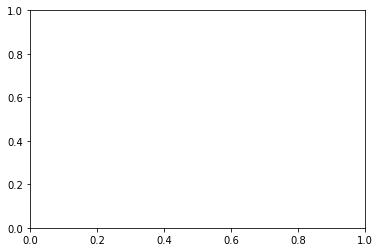

In [2]:
# System
import os, time
import sys
sys.path.insert(0,'/content/drive/My Drive/scBIVI_mc/scBIVI/')

# Math
import numpy as np
import pandas as pd
import scipy.stats as stats
import random
import torch
import scipy
torch.set_default_tensor_type(torch.FloatTensor)


# sc Processing
# import anndata
# import scanpy as sc

# Plots
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.subplots()


In [3]:
# mount to drive and change directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI/

# my modules
import reformat_model

Mounted at /content/drive
/content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI


# Generate parameters


Parameters for cell type will be stored in numpy arrays of shape ( cell_type, gene, parameter): ( N_ct, N_g, 3) for bursty transcription and (N_ct, N_g, 2) for constitutive transcription, where N_ct is the number of cell types, N_g is the number of genes, and 2 and 3 are the number of parameters in bursty and constitutive models of transcription respectively. 

In [4]:
# # LOG of mean and LOG of std dev
# mu_b = 0.2
# mu_beta = 0.5
# mu_gamma = 0.4

# std_b =  0.6
# std_beta = 0.3
# std_gamma = 0.5


# generate genes
def generate_gene_parameters(N_ct, N_g, 
                                    mu_array =  [0.2,0.5,0.4],
                                    std_array = [0.6,0.3,0.5],
                                    correlation_coeff = 0.8,
                                    N_mg = 25,
                                    std_eps = 0.05,
                                    bursty = True):
  ''' Generates the log of gene parameters for a given number of cell types N_ct for a given number of genes N_g. Assumes a bursty model of transcription. 

  Parameters
  ------
  N_ct : number of cell types
  N_g : number of genes


  Optional
  ------
  mu_array : array of means for b, beta, gamma
  std_array : array of standard deviation for b, beta, gamma
  correlation_coeff : correlation scaling to generate parameters for each gene from a correlated multivariate normal dist.
  N_mg : average number of marker genes per cell type (average of a Poisson distribution)
  std_eps : standard deviation for normally distributed random variable used to add noise to housekeeper gene parameters


  Returns
  ------
  param_array = array of size (N_ct, N_g, 3) : 
  '''

  mu_array = np.array(mu_array)
  std_array = np.array(std_array)

  if bursty == False:
    N_params = 2
    if len(mu_array) == 3:
      mu_array = mu_array[1:]
      std_array = std_array[1:]
  else:
    N_params = 3

  # setup covariance matrix
  cov_array = np.zeros((N_params,N_params))

  for i in range(N_params):
    for j in range(N_params):
      rho = correlation_coeff
      if i == j :
        rho = 1
      cov_ij = std_array[i]*std_array[j]*rho
      cov_array[i,j] = cov_ij


  # set up array to store parameters
  param_array = np.zeros((N_ct,N_g,N_params))

  # generate housekeeping genes from multivariate normal distribution
  baseline_params = np.random.multivariate_normal(mean= mu_array, cov = cov_array, size = N_g)

  for ct in range(N_ct):
    param_array[ct,:,:] = baseline_params 
  
  # add some random noise to housekeeping genes
  param_array = param_array + np.random.normal(loc = 0, scale = std_eps, size = (N_ct,N_g,N_params))

  # MARKER genes YAHOO
  possible_marker_genes = list(range(N_g))

  for ct in range(N_ct):
    # choose number of marker genes from Poisson distribution with default average of 25
    num_mg_ = np.random.poisson(lam = N_mg) + 2

    # select which genes they are randomly 
    mg_index = np.array(random.sample(possible_marker_genes,num_mg_))

    # remove the marker genes so that there are no overlapping MGs
    possible_marker_genes = [mg for mg in possible_marker_genes if mg not in mg_index]


    if bursty == False:
      # does k, transcriptional initiation rate, or gamma, degradation, change? 
      a = np.random.uniform(0,1,size = num_mg_)
      mg_k_increase = mg_index[a > 0.45]
      mg_gamma_decrease = mg_index[a < 0.45]

      # modulate marker gene expression
      param_array[ct,mg_k_increase,:] = param_array[ct,mg_k_increase,:] - np.random.normal(loc=1.2, scale = 0.1, size = (len(mg_k_increase),2))
      param_array[ct,mg_gamma_decrease,1] = param_array[ct,mg_gamma_decrease,1] - np.random.normal(loc=1.2, scale = 0.1, size = len(mg_gamma_decrease) )
      
    else: 
      # does k, transcriptional initiation rate, or b, burst size, change? 
      a = np.random.uniform(0,1,size = num_mg_)
      mg_k_increase = mg_index[a < 0.45]
      mg_b_increase = mg_index[a > 0.45]

      # modulate marker gene expression
      param_array[ct,mg_k_increase,-2:] = param_array[ct,mg_k_increase,-2:] - np.random.normal(loc=1.2, scale = 0.1, size = (len(mg_k_increase),2))
      param_array[ct,mg_b_increase,0] = param_array[ct,mg_b_increase,0] + np.random.normal(loc=1.2, scale = 0.1, size = len(mg_b_increase))

  return(param_array)


Amazing! Generating gene parameters for bursty and Poisson model now works. Love that. 


Now to generate full data.

In [5]:
def generate_count_data(N_cells, N_ct, N_g, distribution, bursty = True):
  ''' Generates count data matrix for N_cells, N_celltypes, given a distribution (bursty or constitutive).
    (If I wanted to generate uncorrelated Negative Binomial data or bivariate Negative Binomial data, how would I get the means and std from the current method of parameter sampling?)
  
  Parameters 
  ------
  N_cells : rough number of cells in the count matrix (will be slightly more because rounding up)
  N_ct : number of cell types
  N_genes : number of genes per cell
  distribution : function that defines the distribution to sample from 
  bursty : bursty or constitutive transcription (bool)


  Returns
  -----
  count_matrix : matrix of size ( ~N_cells, N_g, 2) where the third dimension is spliced, unspliced counts. 
  '''

  # calculate the proportion of cells in each cell type -- dirichlet distribution
  alpha = np.ones(N_ct)*4.0  # could change -- i think the higher the multiplied value, the more even the # cells per ct will be
  ct_proportions = np.random.dirichlet(alpha)

  # calculate the number of cells per cell type
  cells_per_ct = np.ceil(ct_proportions * N_cells)

  # set up count matrix -- spliced and unspliced
  count_matrix = np.zeros((int(np.sum(cells_per_ct)),N_g,2))
  count_matrix_MMNB = np.zeros((int(np.sum(cells_per_ct)),N_g,2))  

  # generate log of parameters for all genes for each cell type
  params = generate_gene_parameters(N_ct, N_g , bursty = bursty)

  for i,ct in enumerate(range(N_ct)):

    num_cells_ = cells_per_ct[i]
    params_ = params[ct,:,:]
    
    # generates count matrix of size (num_cells_ , N_g, 2) given distribution and parameters of the distribution
    count_data_ct, count_data_ct_MMNB = distribution(int(num_cells_) , params_) 

    count_matrix[int(np.sum(cells_per_ct[:i])):int(np.sum(cells_per_ct[:i+1])), :, :] = count_data_ct 
    count_matrix_MMNB[int(np.sum(cells_per_ct[:i])):int(np.sum(cells_per_ct[:i+1])), :, :] = count_data_ct_MMNB


  return(count_matrix,params,cells_per_ct,count_matrix_MMNB)
    

In [192]:
# sampling distributions

def constitutive_transcription(num_cells, log_params):
  ''' Produces a count matrix for num_cells_ given constitutive model of transcription and parameters. Spliced and unspliced.
  Uncorrelated Poisson distribution.

  Parameters
  -----
  num_cells : number of cells for which to generate counts
  params : parameters for each gene for a constitutive model of transcription

  Returns
  ---
  count_data : array of size (num_cells_, len(params), 2) with spliced and unspliced data
  '''

  params = 10**log_params
  nascent_means = 1/params[:,0]
  mature_means = 1/params[:,1]

  nascent_counts = np.random.poisson(lam = nascent_means,size = (num_cells,len(params)))
  mature_counts = np.random.poisson(lam = mature_means,size = (num_cells,len(params)))


  count_data = np.zeros((num_cells,len(params),2))
  count_data[:,:,0] = nascent_counts
  count_data[:,:,1] = mature_counts

  return(count_data)


# def NB_count_data(num_cells, params):
#   ''' 
#   UNPHYSICAL MODEL
#   Produces a count matrix for num_cells_ given UNCORRELATED negative binomial distribution and parameters for that model. Spliced and unspliced.
    
#   Parameters
#   -----
#   num_cells : number of cells for which to generate counts
#   params : parameters for each gene

#   Returns
#   ---
#   count_data : array of size (num_cells_, len(params), 2) with spliced and unspliced data
#   '''

#   params = 10**params
#   nascent_means = params[:,0]/params[:,1]
#   mature_means = params[:,0]/params[:,2]

#   nascent_var = nascent_means*(1+params[:,0]) 
#   mature_var = mature_means*(1 + params[:,0]*params[:,1]/(params[:,1]+params[:,2]))

#   n_nascent = nascent_means**2/(nascent_var - nascent_means)
#   p_nascent = nascent_means/nascent_var

#   n_mature = mature_means**2/(mature_var - mature_means)
#   p_mature = mature_means/mature_var

#   nascent_counts = np.random.negative_binomial(n = n_nascent, p = p_nascent, size = (num_cells,len(params)))
#   mature_counts = np.random.negative_binomial(n = n_mature, p = p_mature, size = (num_cells,len(params)))

#   count_data = np.zeros((num_cells,len(params),2))
#   count_data[:,:,0] = nascent_counts
#   count_data[:,:,1] = mature_counts

#   return(count_data)

def bursty_transcription(num_cells, log_params):
  ''' Generates count data for a bursty model of transcription. Spliced and unspliced data.

  Sampling works as follows:

  1. Pull from nascent NB given moments of the CME solution to get nascent counts. 
  2. Run the parameter through the NN to return weights and hyperparameters. 
  3. Pull from a discrete distribution of kernel functions with probabilities given by NN weights. 
  4. Sample from the NB kernel function of the chosen kernel function to get mature counts. 

  Parameters
  ------
  num_cells : number of cells to generate count data for
  log_params : parameters of genes for a bursty model of transcription (log of params)

  Returns
  ------
  count_matrix : matrix of count data size (num_cells, N_g, 2)
  '''
  eps = 1e-8

  params = 10**log_params
  b,beta,gamma = params[:,0],params[:,1],params[:,2]


  # calculate nascent marginal negative binomial P(n) 
  n_nascent = 1/beta
  p_nascent = 1/(b+1)

  nascent_counts = np.random.negative_binomial(n = n_nascent, p = p_nascent, size = (num_cells, len(params)))

  weights, n_10_mature, p_10_mature, mu_10_mature, logmean_cond, logvar_cond = get_NN_weights_NB_params(params, nascent_counts.flatten(), num_cells)

  # draw which distribution based on weights for each nascent value

  n_mature, p_mature, mu_mature = np.zeros(len(nascent_counts.flatten())), np.zeros(len(nascent_counts.flatten())), np.zeros(len(nascent_counts.flatten()))

  mature_counts = np.zeros(len(nascent_counts.flatten()))
  mature_counts_MMNB = np.zeros(len(nascent_counts.flatten()))
  print('YEEHAW')
  for i,n in enumerate(nascent_counts.flatten()):
    
    weights_ = weights[i]
    n_10_mature_ = n_10_mature[i]
    p_10_mature_ = p_10_mature[i]
    mu_10_mature_ = mu_10_mature[i]
    var_10_mature_ = mu_10_mature_/(1-p_10_mature_)

    # mu_i = np.sum(mu_10_mature_*weights_)
    # var_i = np.sum((weights_**2)*var_10_mature_)
    # n_i = mu_i**2/(var_i-mu_i)
    # p_i = mu_i/var_i
    # n_mature[i], p_mature[i], mu_mature[i] = n_i, p_i, mu_i


    NB_index = np.random.choice(range(10),p = weights_)
    print(weights_[NB_index])
    #NB_index = np.where(weights_ == np.max(weights_))

    n_mature[i], p_mature[i], mu_mature[i] = n_10_mature_[NB_index], p_10_mature_[NB_index], mu_10_mature_[NB_index]



  mean_cond = np.exp(logmean_cond + logvar_cond/2)
  var_cond = np.exp(2*logmean_cond + logvar_cond) * (np.exp(logvar_cond) - 1)
  n_cond = mean_cond**2/(var_cond-mean_cond)
  p_cond = mean_cond/var_cond

  filt_nb = np.logical_and(p_cond > 1e-10, n_cond > 0)
  filt_poisson = ~filt_nb

  mature_counts_MMNB[filt_poisson] =  np.random.poisson(lam = mu_mature[filt_poisson])
  mature_counts_MMNB[filt_nb] =  np.random.negative_binomial(n = n_cond[filt_nb], p = p_cond[filt_nb])
  mature_counts_MMNB = mature_counts_MMNB.reshape(nascent_counts.shape)

  index_nb = np.logical_and(p_mature > 1e-10, n_mature > 0)
  index_poisson = ~index_nb
  mature_counts[index_poisson] = np.random.poisson(lam = mu_mature[index_poisson])
  mature_counts[index_nb] = np.random.negative_binomial(n = n_mature[index_nb], p = p_mature[index_nb])
  mature_counts = mature_counts.reshape(nascent_counts.shape)

  count_data = np.zeros((num_cells,len(params),2))
  count_data[:,:,0] = nascent_counts
  count_data[:,:,1] = mature_counts

  count_data_MMNB = np.zeros((num_cells,len(params),2))
  count_data_MMNB[:,:,0] = nascent_counts
  count_data_MMNB[:,:,1] = mature_counts_MMNB


  return(count_data, count_data_MMNB)

In [193]:
def get_NN_weights_NB_params(params, nascent_values, num_cells):
    ''' Get models for bivariate lognormal given parameter values. 

    Parameters 
    ------
    params: parameters of a bursty model of transcription (b,beta,gamma) NOT LOG -- IMPORTANT
    nascent_values : nascent count values at which to evaluate

    Returns
    ------
    weights : weights for the NB distribution for each cell/gene 
    hyp : 
    '''
    b,beta,gamma = torch.tensor(params[:,0]).repeat(num_cells),torch.tensor(params[:,1]).repeat(num_cells),torch.tensor(params[:,2]).repeat(num_cells)
    mu1,mu2 = b/beta, b/gamma

    # get moments
    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)

    nascent_values = torch.tensor(nascent_values)

    # calculate conditional moments
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    # val = (logmean1 + logmean2 + (logvar1 + logvar2)/2)
    # val[val<-88] = -88

    logcov = np.log(cov * np.exp(-(logmean1 + logmean2 + (logvar1+logvar2)/2) ) + 1 )
    #logcov = torch.log(cov * torch.exp(-(val)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)

    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(nascent_values+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  
    logstd_cond = logstd2 * torch.sqrt(1-logcorr**2)  

    xmax_m = torch.ceil(torch.ceil(mu2) + 4*torch.sqrt(var2))
    xmax_m = torch.clip(xmax_m,30,np.inf).int()
  

    # reshape and stack
    pv = torch.column_stack((torch.log10(b).reshape(-1),
                             torch.log10(beta).reshape(-1),
                             torch.log10(gamma).reshape(-1),
                             logmean_cond.reshape(-1),
                             logstd_cond.reshape(-1),
                             xmax_m.reshape(-1),
                             nascent_values.reshape(-1)
                             ))
    
    pv = pv.to(torch.float)


    # run through model
    w,hyp = reformat_model.model(pv.to(torch.device('cuda')))

    hyp = hyp*5+1

    p_vec = 10**pv[:,0:3]
    logmean_cond = pv[:,3]
    logstd_cond = pv[:,4]
        
    grid = reformat_model.generate_grid(logmean_cond,logstd_cond,reformat_model.NORM).to(torch.device('cuda'))

    s = torch.zeros((len(nascent_values),10)).to(torch.device('cuda'))
    s[:,:-1] = torch.diff(grid,axis=1)
    s *= hyp
    s[:,-1] = torch.sqrt(grid[:,-1])
    v = s**2
    r = grid**2/(v-grid)
    p_nb = 1-grid/v

    #return(w.cpu(),hyp.cpu(),pv.cpu())
    return(w.cpu().detach().numpy(),r.cpu().detach().numpy(),p_nb.cpu().detach().numpy(), grid.cpu().detach().numpy(),logmean_cond.cpu().detach().numpy(),logvar_cond.cpu().detach().numpy())

In [194]:
def get_nnNB_prob(log_params,n,m):

  params = 10**log_params
  nascent_values = np.array([[i]*m for i in range(n)]).flatten()

  w,hyp,pv = get_NN_weights_NB_params(params, nascent_values, num_cells = n*m)

  nas = nascent_values.reshape(-1,1)
  mat = torch.arange(m).repeat(n).reshape(-1,1)

  # get conditional probabilites
  ypred_cond = reformat_model.get_ypred_at_RT(pv,w,hyp,nas,mat,reformat_model.NORM)
  print(ypred_cond)

  b,beta,gamma = params[:,0],params[:,1],params[:,2]

  # calculate nascent marginal negative binomial P(n) 
  n_nb = 1/beta
  p_nb = 1/(b+1)

  prob_nascent = torch.tensor(stats.nbinom.pmf(k=nascent_values, n=n_nb, p=p_nb)).reshape(n,m)

  # multiply conditionals P(m|n) by P(n)
  predicted = prob_nascent * ypred_cond.reshape(n,m)
  return(predicted)

In [190]:
get_nnNB_prob(log_params = np.array([[0.5,0.8,0.3]]),n=10,m=10).detach().numpy()

ValueError: ignored

In [76]:
!jupyter nbconvert --to python reformat_model

[NbConvertApp] Converting notebook reformat_model.ipynb to python
[NbConvertApp] Writing 6795 bytes to reformat_model.py


In [77]:
#import importlib
importlib.reload(reformat_model)

<module 'reformat_model' from '/content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI/reformat_model.py'>

# CHECK THAT THE NN IS STILL PRODUCING NICE VALUES




In [195]:
bursty_counts,bursty_params,cells_per_ct,bursty_counts_MMNB = generate_count_data(N_cells = 7000, N_ct = 1, N_g = 35, distribution = bursty_transcription, bursty = True)

Streaming output truncated to the last 5000 lines.
0.088170834
0.83395463
0.56073165
0.20153375
0.46222505
0.35823008
0.37914488
0.35248184
0.16395903
0.14291732
0.5533427
0.2791997
0.11418032
0.24722332
0.14573747
0.4155248
0.3383323
0.28049013
0.31058502
0.14141667
0.5719842
0.14048474
0.26722753
0.41054577
0.6649108
0.34276187
0.17232817
0.53854805
0.20772786
0.05070177
0.34896088
0.10015732
0.19830061
0.21104516
0.22656474
0.03522143
0.70520025
0.56073165
0.06058839
0.7592063
0.29523194
0.37674347
0.28648502
0.2024854
0.12909369
0.63454986
0.1994249
0.4647524
0.24722332
0.31544825
0.07601102
0.3470847
0.024993163
0.23684432
0.14141667
0.34748155
0.10991689
0.6172948
0.1667673
0.5688252
0.22919427
0.1553941
0.9158835
0.22848839
0.03257001
0.21637781
0.4759082
0.10701523
0.6423686
0.5159141
0.60228795
0.6204554
0.18041117
0.38159683
0.3642433
0.10732506
0.1315354
0.28648502
0.29647258
0.7872443
0.10425089
0.1515071
0.08243497
0.08022837
0.33270082
0.14201859
0.36907223
0.29115376
0.1

In [ ]:
def make_adata_object(bursty_counts,cells_per_ct):
  cell_type_names = [f'CT{i}' for i in range(len(cells_per_ct))]
  cell_types = []

  for i,ct in enumerate(cell_type_names):
    cell_types = cell_types + [ct]*int(cells_per_ct[i])

  adata_unspliced = anndata.AnnData(bursty_counts[:,:,0])
  adata_spliced = anndata.AnnData(bursty_counts[:,:,1])
  adata_unspliced.var_names = adata_unspliced.var_names + '-u'
  adata_spliced.var['Spliced']   = True
  adata_unspliced.var['Spliced'] = False
  adata = anndata.concat([adata_unspliced,adata_spliced],axis=1)
  adata.obs['Cell Type'] = cell_types

  # normalize and such idk 
  adata.layers['counts'] = adata.X.copy()
  adata = adata[adata.X.sum(axis=1) > 0]

  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.log1p(adata)

  return(adata)

In [ ]:
adata = make_adata_object(bursty_counts,cells_per_ct)

NameError: ignored

In [ ]:
adata

NameError: ignored

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=2)
#sc.tl.leiden(adata, resolution = 0.1)

NameError: ignored

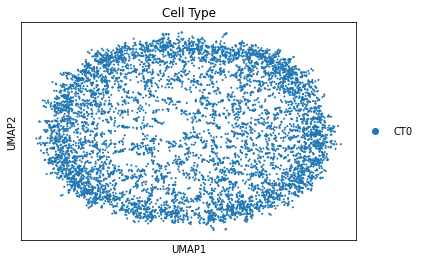

In [ ]:
# should see cell types :D 
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Cell Type'])

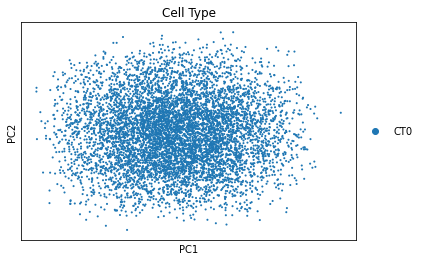

In [ ]:
sc.pl.pca(adata,color='Cell Type')

In [ ]:
# adata.write_loom('./data/synthetic_data/const_5ct')
# np.save('./data/synthetic_data/const_5ct_params',const_params)

The loom file will lack these fields:
{'X_pca', 'X_umap', 'PCs'}
Use write_obsm_varm=True to export multi-dimensional annotations


# Check Bursty Model



Compare bursty model of transcription against true CME solutions. Figure out what might be going wrong.

In [48]:
from exact_cme import calculate_exact_cme

In [196]:
gene = 1
nascent = bursty_counts[:,gene,0]
mature = bursty_counts[:,gene,1]

nascent_MMNB = bursty_counts_MMNB[:,gene,0]
mature_MMNB = bursty_counts_MMNB[:,gene,1]


gene_param = bursty_params[0,gene,:]

#gene_param = np.array([[.2,0.9,0.7]])
def x_func(x):
  '4 sigma away is the default.'
  return(x)

params, CME_ground_truth = calculate_exact_cme(gene_param,'quad_vec',x_func)


n = CME_ground_truth.shape[0]
m = CME_ground_truth.shape[1]

#nnNB_approx = get_nnNB_prob(log_params = gene_param,n=n,m=m).detach().numpy()

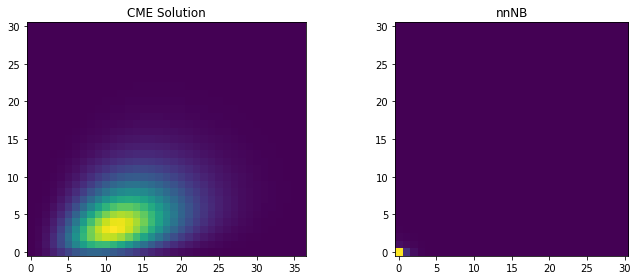

In [174]:
fig,ax = plt.subplots(1,2,figsize=(10,4))


ax[0].set_title('CME Solution')
ax[0].imshow(CME_ground_truth)
ax[0].invert_yaxis()
# ax[1].set_xlim(0,16)
# ax[1].set_ylim(0,7)

ax[1].imshow(nnNB_approx)
ax[1].set_title('nnNB')
ax[1].invert_yaxis()

plt.tight_layout()

In [197]:
possible_n_m = [(i,j) for i in range(CME_ground_truth.shape[0]) for j in range(CME_ground_truth.shape[1])]

In [198]:
index = np.random.choice(range(len(possible_n_m)), p = CME_ground_truth.flatten(),size = 7000)
n_m_selected = np.array(possible_n_m)[index]

In [199]:
nascent_CME = n_m_selected[:,0]
mature_CME = n_m_selected[:,1]

In [206]:
ind = np.argpartition(mature, -200)[-200:]
mature[ind]
mature_test = mature[mature<50]

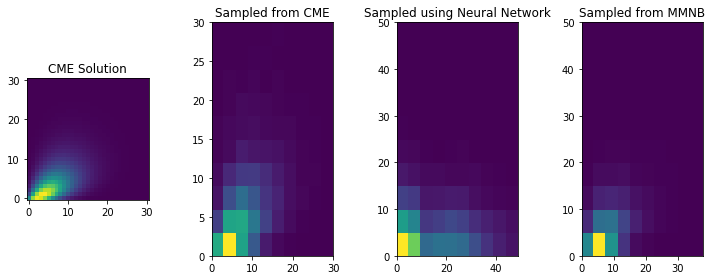

In [208]:
fig,ax = plt.subplots(1,4,figsize=(10,4))


ax[0].set_title('CME Solution')
ax[0].imshow(CME_ground_truth)
ax[0].invert_yaxis()
# ax[1].set_xlim(0,16)
# ax[1].set_ylim(0,7)

ax[1].hist2d(mature_CME,nascent_CME)
ax[1].set_title('Sampled from CME')

ax[2].hist2d(mature_test,nascent[range(len(mature_test))])
ax[2].set_title('Sampled using Neural Network')
#ax[1].set_xlim(0,40)
#ax[1].set_ylim(0,7)

ax[3].hist2d(mature_MMNB,nascent_MMNB)
ax[3].set_title('Sampled from MMNB');

plt.tight_layout()

3.2755675496284673 0.636386901364722 0.43607682966039657


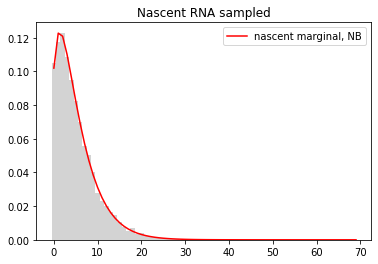

In [201]:
b,beta,gamma = 10**gene_param
print(b,beta,gamma)
p_nb = 1/(b+1)
n_nb = 1/beta
bins = np.arange(nascent.max()+2)-0.5
plt.hist(nascent,bins,color='lightgray',density=True)
x = np.arange(nascent.max()+20)
y = scipy.stats.nbinom.pmf(x,n_nb,p_nb)
plt.plot(x,y,'r-',label='nascent marginal, NB')
plt.legend()
plt.title('Nascent RNA sampled');

In [180]:

# b,beta,gamma = 10**bursty_params[0,i:i+2,0],10**bursty_params[0,i:i+2,1],10**bursty_params[0,i:i+2,2]


# n_nascent = 1/beta
# p_nascent = 1/(b+1)

# a =  np.random.negative_binomial(n = n_nascent, p = p_nascent, size = (1000,2)) 

# x = range(50)
# exact_1,exact_2 = scipy.stats.nbinom.pmf(x,n_nascent[0],p_nascent[0]),scipy.stats.nbinom.pmf(x,n_nascent[1],p_nascent[1])


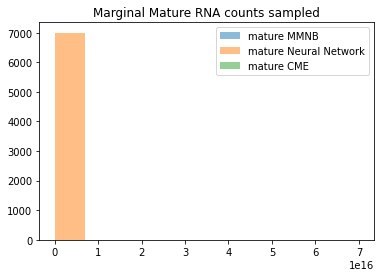

In [188]:
plt.hist(mature_MMNB,label='mature MMNB',alpha=0.5)
plt.hist(mature,label='mature Neural Network',alpha=0.5)
plt.hist(mature_CME,label='mature CME',alpha=0.5)

plt.title('Marginal Mature RNA counts sampled')
plt.legend();